<a href="https://colab.research.google.com/github/ckevar/Conv4MammographyAbnormalities/blob/main/Pre_Trained_4classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Libraries Mounting Drive 
The following classifier is designed for descriminating 4 classes and it's based on a pre-trained model. For such a purposes the VGG16 and InceptionV3 model will be called, modified, compared and then tested.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np 
import os

import requests

from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.optimizers import Adam
from tensorflow.compat.v1.keras import backend
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Models to adopt
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3

from google.colab import output
from google.colab import drive

# Mounting Drive
drive.mount("/content/gdrive")
base_path = "/content/gdrive/My Drive/CI_proj/"
metrics_path = base_path+"metrics/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#Loading Data
only training data is load into the enviroment

In [ ]:
img = np.load(base_path+'dataset/train_tensor.npy') 
labels = np.load(base_path+'dataset/train_labels.npy') 
depth, width, height = img.shape # shape of the train label depth_val, width_val, height_val = images_val.shape # shape of the train label

#Pre-Processing data
Since both VGG16 and InceptionV3 need a 3-channel image, the monochormatic mammograpies are casted into 3-channels by copying its unique channel to the other channels.

This is a four class classifier, therefore, the labels are hot one enconded as follows:

[Benign Mass, Malignant Mass, Benign Calcification, Malignant Calcification]

In [ ]:
labels_train = np.array([]);
idx = [];

# Extracting Abnormalities from data set, and vectorizing the training labels
for i in range(depth):

  if (labels[i] == 1):    # Mass, Benign
    idx.append(i)
    labels_train = np.append(labels_train, [1., 0., 0., 0.])

  elif (labels[i] == 2):  # Mass, Malignant
    idx.append(i)
    labels_train = np.append(labels_train, [0., 1., 0., 0.])

  elif (labels[i] == 3):  # Calcification, Benign
    idx.append(i)
    labels_train = np.append(labels_train, [0., 0., 1., 0.])

  elif (labels[i] == 4):  # Calcification, Malignant
    idx.append(i)
    labels_train = np.append(labels_train, [0., 0., 0., 1.])

# Filter abnormalities from full image set
img2 = img[idx];
depth = idx.__len__()
labels_train = labels_train.reshape(depth, 4)

# 3-COLOUR CHANNELS
# Triple the black and white colour to a 3-colour channel 
img = np.zeros((depth, width, height, 3))

for i in range(depth):
  img[i, :, :, 0] = img2[i]
  img[i, :, :, 1] = img2[i]
  img[i, :, :, 2] = img2[i]

# Normalization
img = img.astype('float32') / 65535;

#Plot Some Samples

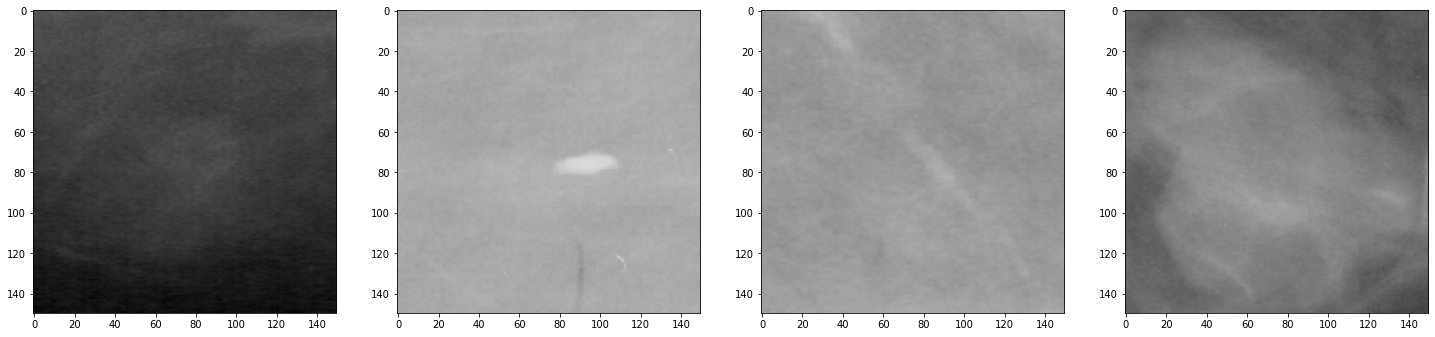

In [ ]:
toPlot = np.random.randint(depth, size = 4)

plt.figure(figsize=(25, 10))
for x in range(toPlot.__len__()):
  plt.subplot(1, 4, x + 1)
  plt.imshow(img[toPlot[x]])

#Helper Function

In [ ]:
def reset_weights(md):
  # resets the weights of a model in the tensor flow in a session
  session = backend.get_session()
  for layer in md.layers:
      backend.clear_session()

def loadResultMetrics(fileName):
  # load metric files
  a = np.load(fileName)
  return a[0], a[1], a[2], a[3]

def BotNotifier(message):
    # sends "message" through telegram bot
    TOKEN = "995731858:AAHrY8FYsa0sE6zKkRGtkZgdLo7-VDjvORo"
    CHAT_ID = "597192342"
    URL = "https://api.telegram.org/bot{}/".format(TOKEN)
    url = URL + "sendMessage?text={}&chat_id={}".format(message, CHAT_ID)
    response = requests.get(url)

def PlotFiles(arg):
  # plots n = len(arg) metrics filles of training and loss
  plt.figure(figsize=(25, 8))

  acc = []
  loss = []
  val_acc = []
  val_loss = []

  for files in arg:
    if files is not None:
      acc, loss, val_acc, val_loss = loadResultMetrics(os.path.join(metrics_path, files))
      plt.subplot(1, 2, 1)
      plt.plot(acc, label = 'Train ' + files)
      plt.plot(val_acc, label = 'Val acc ' + files)
      plt.subplot(1, 2, 2)
      plt.plot(loss, label="Training loss " + files)
      plt.plot(val_loss, label="Val loss " + files)

  plt.subplot(1, 2, 1)
  plt.grid()
  plt.legend()
  plt.subplot(1, 2, 2)
  plt.grid()
  plt.legend()

def runModel_generator_w_KFold(model, img, labels_train, optmz, kFold, epoch, batch_size):
  # Implements K-FOLD with augmented data
  depth, _, _, _ = img.shape;
  chunk = depth // kFold

  idx = np.arange(depth);
  np.random.shuffle(idx);

  # Metrics vectors
  acc = []
  loss = []
  val_acc = []
  val_loss = []

  # Generators set-up
  train_datagen = ImageDataGenerator(rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     )

  # Validation set-up
  valid_datagen = ImageDataGenerator(rescale=1.)

  # Compile
  model.compile(optimizer = optmz, loss="categorical_crossentropy", metrics = ['accuracy'])
  model.save_weights(base_path+'task32_pretrained.h5')

  # Area under accuracy curve
  val_acc_int = 0.0  

  for fold in range(kFold):
    print('START,',fold+1,'/',kFold,'--------------------------------------------------------------------------------')
    
    # k-fold algorithm
    valid = idx[fold * chunk : (fold + 1) * chunk];
    train = np.concatenate((idx[:fold * chunk], idx[(fold + 1) * chunk:]), axis=0)
    
    # Genetors 
    train_generator = train_datagen.flow(img[train], labels_train[train], batch_size=batch_size)
    valid_generator = valid_datagen.flow(img[valid], labels_train[valid])

    model.load_weights(base_path+'task32_pretrained.h5')

    # Train model
    h = model.fit(train_generator, steps_per_epoch=np.ceil(train.shape[0]/batch_size), 
                  epochs=epoch, validation_data=valid_generator, 
                  validation_steps=np.ceil(valid.shape[0]/batch_size), verbose=0)    
    
    # log metrics
    val_acc_0 = h.history['val_accuracy'];
    acc.append(h.history['accuracy'])
    loss.append(h.history['loss'])
    val_acc.append(val_acc_0)
    val_loss.append(h.history['val_loss'])
    print('=> acc:',acc[-1][-1], 'loss:',loss[-1][-1], 'val_acc:',val_acc[-1][-1], 'val_loss:',val_loss[-1][-1])
    print('DONE------------------------------------------------------------------------------------------')
    reset_weights(model)

    val_acc_int += np.sum(val_acc_0, axis=0);
    
    print('Area Below Accuracy is ' , val_acc_int / (fold + 1.0))

  # average metrics  
  acc = np.average(acc, axis=0)
  loss = np.average(loss, axis=0)
  val_acc = np.average(val_acc, axis=0)
  val_loss = np.average(val_loss, axis=0)

  return acc, loss, val_acc, val_loss, val_acc_int/5.0

def trainerNtimes_generator_saveInitModel(n_times, genModelx, arg, img, labels_train, lr, k, EPOCH, BATCH, saveIt, fileName):
  # Runs the k-fold algorithm n_times 

  # metrics vectors
  acc = []
  loss = []
  val_acc = []
  val_loss = []

  # send message a training has started
  BotNotifier("Starting task32 with " + str(arg))

  for x in range(n_times):
    print('[RUNNING@',x,'] with arg',arg)
    backend.clear_session()

    # Creating optimizer and model
    adam = Adam(lr=lr);
    model = genModelx(arg);

    # Running k-fold algorithm
    a, b, c, d, aba = runModel_generator_w_KFold(model, img, labels_train, adam, k, EPOCH, BATCH)
    
    # release memory
    del model
    del adam

    # log metrics
    acc.append(a)
    loss.append(b)
    val_acc.append(c)
    val_loss.append(d)

  # average metrics
  acc = np.average(acc, axis=0)
  loss = np.average(loss, axis=0)
  val_acc = np.average(val_acc, axis=0)
  val_loss = np.average(val_loss, axis=0)

  # save metrics
  if (saveIt): 
    np.save(fileName + ".npy", np.stack((acc, loss, val_acc, val_loss)))

  # bot notfies training is done 
  BotNotifier("Done on task31 with " + str(arg) + " ABA: " + str(aba));
  return acc, loss, val_acc, val_loss

#General Parameters

In [ ]:
k = 5;      # this represents the 20 % of data set provided
EPOCH = 50  # Epochs per training
BATCH = 64  # Size of the batch
learning_rate = 0.0001 # Learning Rate
save_model = True       # variable to enable/disable the saving of generated model
times2run_trainer = 1   # Times the trainer will run on the same (the model restarts between trainings)

The first architecture will be a pre-trained model + 1-neuro output layer, this also will be used as control performance. As in the previous task, the pre-trained model will be used as feature extractor, training only the weights on the last layer. the second stage of the training is to fine-tune to adjust the kernels inside the pre-trained model.

In [ ]:
def GeneralPreTrainedModel(arg):
  
  # add new classifier layers
  flat1 = layers.Flatten()(arg.layers[-1].output)
  # 4 OUTPUTS with SOFTMAX
  output = layers.Dense(4, activation='softmax')(flat1)

  # define new pre-trained model
  model_return = models.Model(inputs=arg.inputs, outputs=output)

  # summarize the pre-trained model
  model_return.summary()
  return model_return

#Model VGG16 as Feature Extractor
The first pre-trained to be evaluated is the VGG16

In [ ]:
pre_trained_model = VGG16(include_top=False, input_shape=(width, height, 3)) # VGG16 model

# Set the model as feature 
pre_trained_model.trainable = False

58892288/58889256 [==============================] - 1s 0us/step


[RUNNING@ 0 ] with arg <tensorflow.python.keras.engine.functional.Functional object at 0x7f2883f839e8>
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


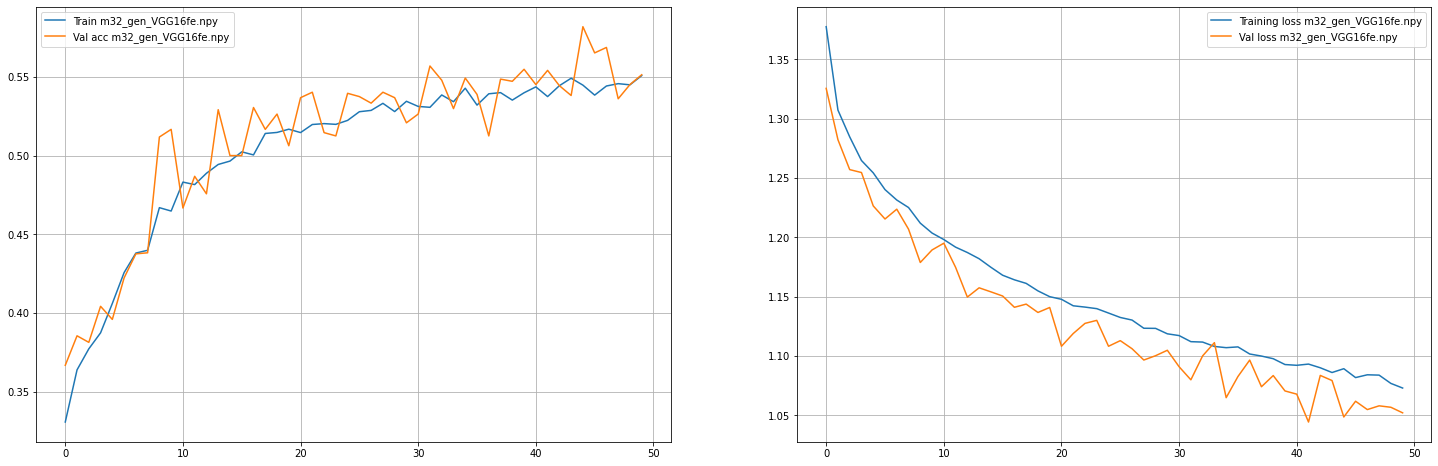

In [ ]:
trainerNtimes_generator_saveInitModel(times2run_trainer, GeneralPreTrainedModel,
                                      pre_trained_model, img, labels_train, 
                                      learning_rate, k, EPOCH, BATCH, save_model, 
                                      os.path.join(metrics_path, "m32_gen_VGG16fe"))
PlotFiles(("m32_gen_VGG16fe.npy", None))

## VGG16 Fine Tunning

[RUNNING@ 0 ] with arg <tensorflow.python.keras.engine.functional.Functional object at 0x7f2883f839e8>
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

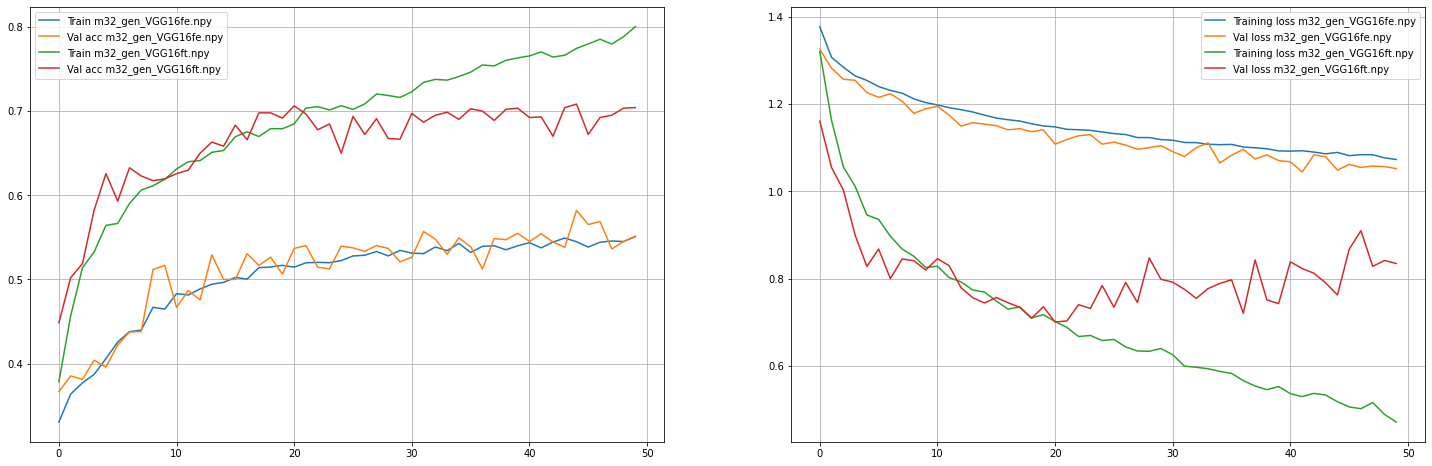

In [ ]:
pre_trained_model.trainable = True
trainerNtimes_generator_saveInitModel(times2run_trainer, GeneralPreTrainedModel, 
                                      pre_trained_model, img, labels_train, 
                                      learning_rate, k, EPOCH, BATCH, save_model, 
                                      os.path.join(metrics_path, "m32_gen_VGG16ft"))
PlotFiles(("m32_gen_VGG16fe.npy", "m32_gen_VGG16ft.npy"))

As expected the fine-tuned model performed way better than the feature extractor model in terms of accuracy and learning speed, however, at 20th epoch it starts over-fitting the mapping.

#InceptionV3 as Feature Extractor
In this experiment the InceptionV3 is evaluated. As usual, two-stage training has been applied.

In [ ]:
pre_trained_model = InceptionV3(include_top=False, input_shape=(width, height, 3)) 

# Set the model as feature 
pre_trained_model.trainable = False

87916544/87910968 [==============================] - 1s 0us/step


[RUNNING@ 0 ] with arg <tensorflow.python.keras.engine.functional.Functional object at 0x7f28244685c0>
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


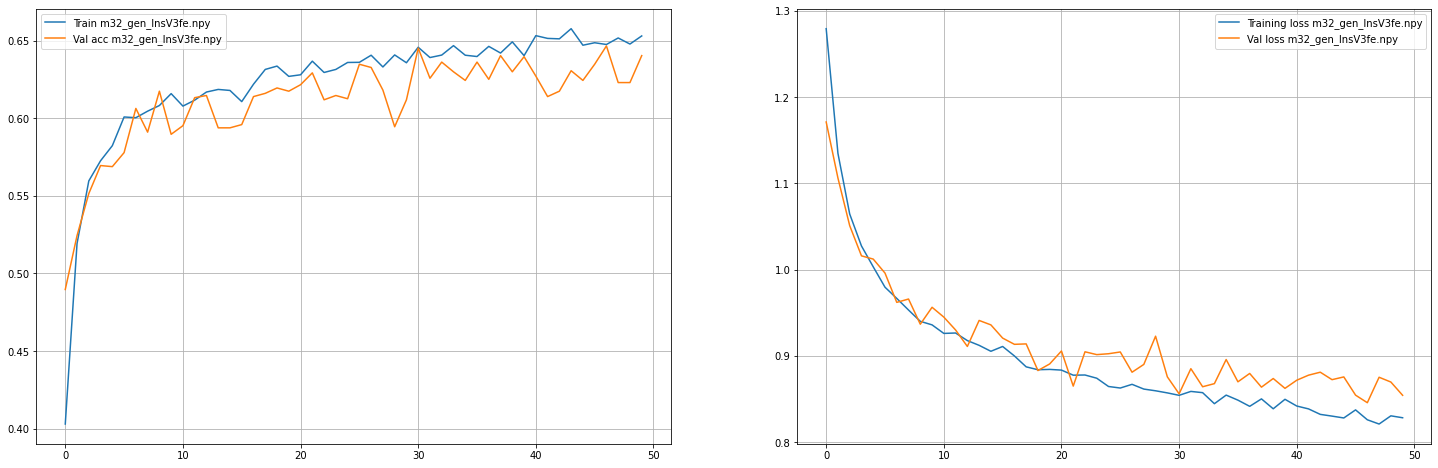

In [ ]:
trainerNtimes_generator_saveInitModel(times2run_trainer, GeneralPreTrainedModel, 
                                      pre_trained_model, img, labels_train, 
                                      learning_rate, k, EPOCH, BATCH, save_model, 
                                      os.path.join(metrics_path, "m32_gen_InsV3fe"))
PlotFiles(("m32_gen_InsV3fe.npy", None))

## InceptionV3 Fine Tunning

[RUNNING@ 0 ] with arg <tensorflow.python.keras.engine.functional.Functional object at 0x7f28244685c0>
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

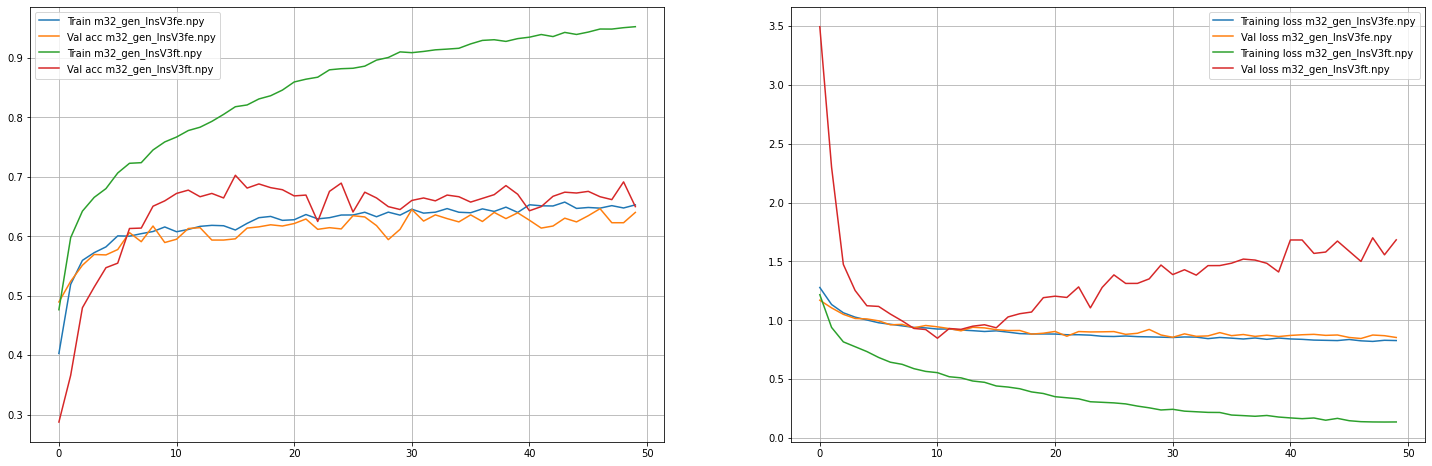

In [ ]:
pre_trained_model.trainable = True
trainerNtimes_generator_saveInitModel(times2run_trainer, GeneralPreTrainedModel,
                                      pre_trained_model, img, labels_train, 
                                      learning_rate, k, EPOCH, BATCH, save_model, 
                                      os.path.join(metrics_path, "m32_gen_InsV3ft"))
PlotFiles(("m32_gen_InsV3fe.npy", "m32_gen_InsV3ft.npy"))

As expected the fine-tuned IncptionV3 model performs better than its feature extractor counterpart in terms of accuracy; meanwhile, the loss and learning are not significantly different. 

#Model with A Dense Layer
From the learning curves of the feature extractor models, it seems the last layers needs more trainable parameters to enhance its mapping mammography-label, this means more features in the intermediated layer; therefore, in this new approach a dense layer is placed between the output layer and the pre-trained model.

In [ ]:
def GeneralPreTrainedModelDense(arg):
  
  # add new classifier layers
  flat1 = layers.Flatten()(arg.layers[-1].output)
  dense1 = layers.Dense(2048, activation='relu')(flat1)
  # 4 OUTPUTS with SOFTMAX
  output = layers.Dense(4, activation='softmax')(dense1)

  # define new pre-trained model
  model_return = models.Model(inputs=arg.inputs, outputs=output)

  # summarize the pre-trained model
  model_return.summary()
  return model_return

##VGG16
VGG16 is the first model to be evaluated. As usual to trained stages are performed,even though, this experiment only is focus on the feature extractor. 

In [ ]:
del pre_trained_model
pre_trained_model = VGG16(include_top=False, input_shape=(width, height, 3)) # VGG16 model

# Set the model as feature 
pre_trained_model.trainable = False

[RUNNING@ 0 ] with arg <tensorflow.python.keras.engine.functional.Functional object at 0x7f177008d080>
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

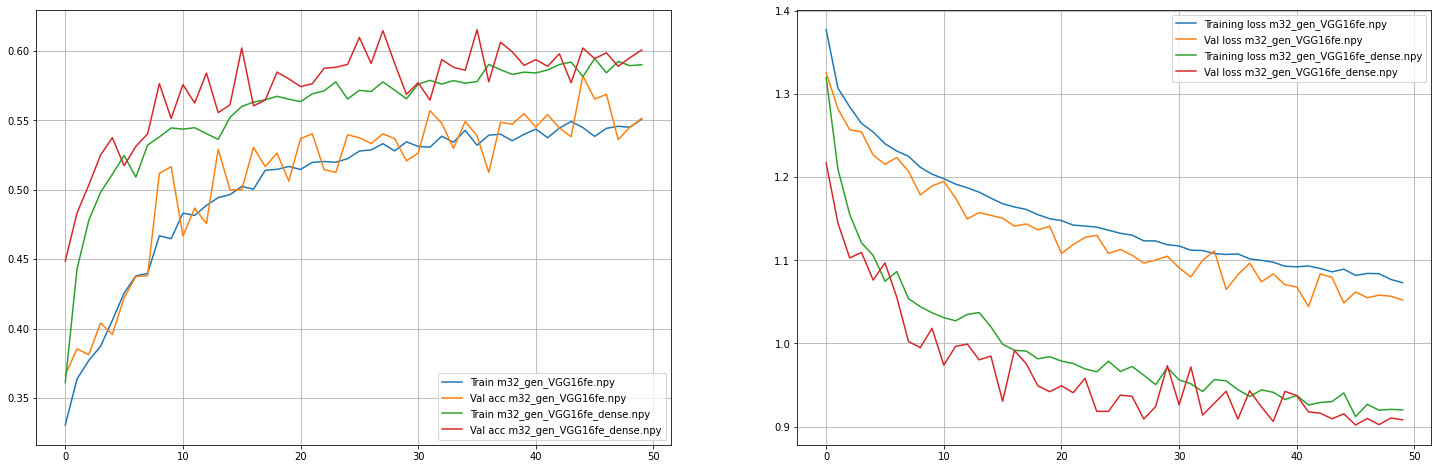

In [ ]:
trainerNtimes_generator_saveInitModel(times2run_trainer, GeneralPreTrainedModelDense,
                                      pre_trained_model, img, labels_train, learning_rate, 
                                      k, EPOCH, BATCH, save_model, 
                                      os.path.join(metrics_path, "m32_gen_VGG16fe_dense"))
PlotFiles(("m32_gen_VGG16fe.npy", "m32_gen_VGG16fe_dense.npy"))

Results of the feature extraction model shows the model with an addional dense layer shows better result than without that dense layer.

###Fine Tunning

[RUNNING@ 0 ] with arg <tensorflow.python.keras.engine.functional.Functional object at 0x7f177008d080>
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

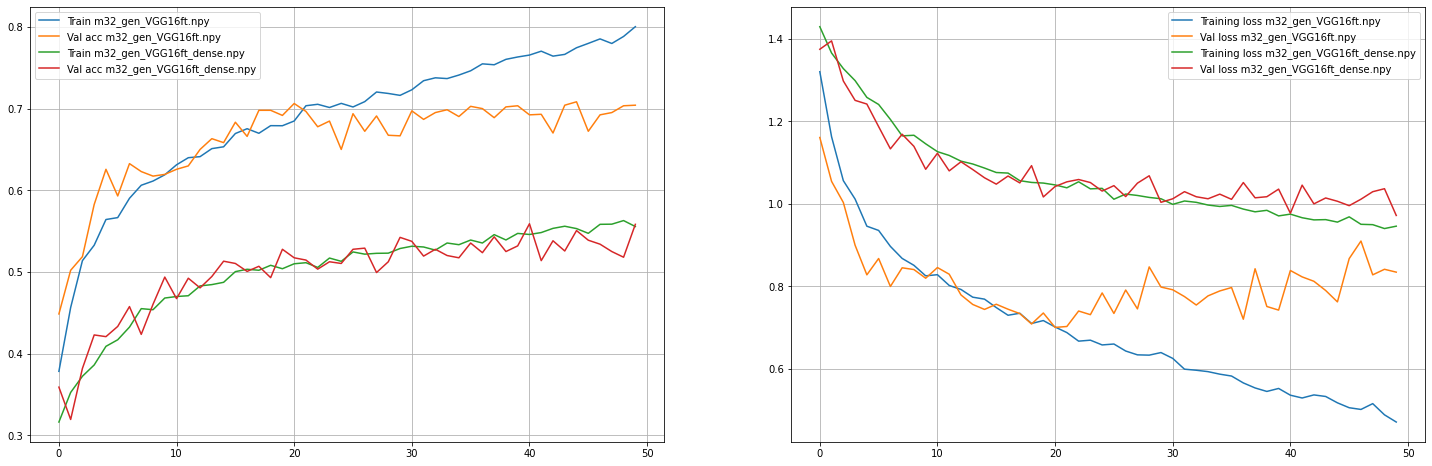

In [ ]:
pre_trained_model.trainable = True
trainerNtimes_generator_saveInitModel(times2run_trainer, GeneralPreTrainedModelDense,
                                      pre_trained_model, img, labels_train, learning_rate, 
                                      k, EPOCH, BATCH, save_model, 
                                      os.path.join(metrics_path, "m32_gen_VGG16ft_dense"))
PlotFiles(("m32_gen_VGG16ft.npy", "m32_gen_VGG16ft_dense.npy"))

On the other hand, fine-tuning the model with an addional dense layer did not goot at all in comparison to the flatten model.

##InceptionV3 
The next pre-trained model evaluated with an addional dense layer is the inceptionV3. Although, this experiment only focuses on the feature extractor approach, the fine-tuning also will be executed.

In [ ]:
pre_trained_model = InceptionV3(include_top=False, input_shape=(width, height, 3)) 

# Set the model as feature 
pre_trained_model.trainable = False

[RUNNING@ 0 ] with arg <tensorflow.python.keras.engine.functional.Functional object at 0x7f4159448128>
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 74, 74, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_94[0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

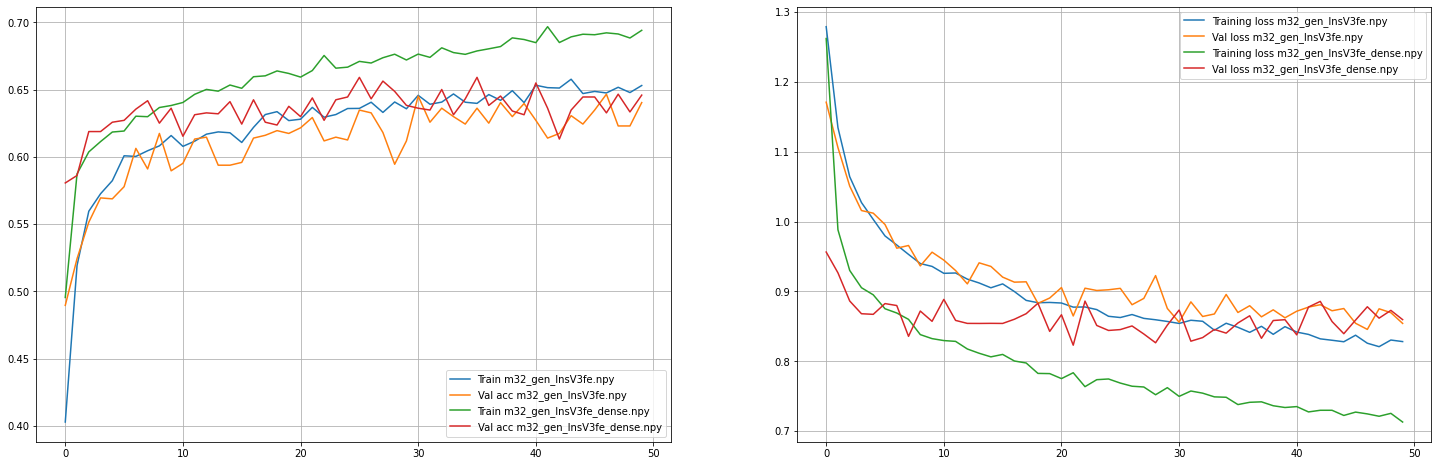

In [ ]:
trainerNtimes_generator_saveInitModel(times2run_trainer, GeneralPreTrainedModelDense, 
                                      pre_trained_model, img, labels_train, learning_rate, 
                                      k, EPOCH, BATCH, save_model, 
                                      os.path.join(metrics_path, "m32_gen_InsV3fe_dense"))
PlotFiles(("m32_gen_InsV3fe.npy", "m32_gen_InsV3fe_dense.npy"))

Unlike the VGG16 models, the additional layer on the InceptionV3 does not do significant performance.

###Fine Tunning

[RUNNING@ 0 ] with arg <tensorflow.python.keras.engine.functional.Functional object at 0x7f4159448128>
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 74, 74, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_94[0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

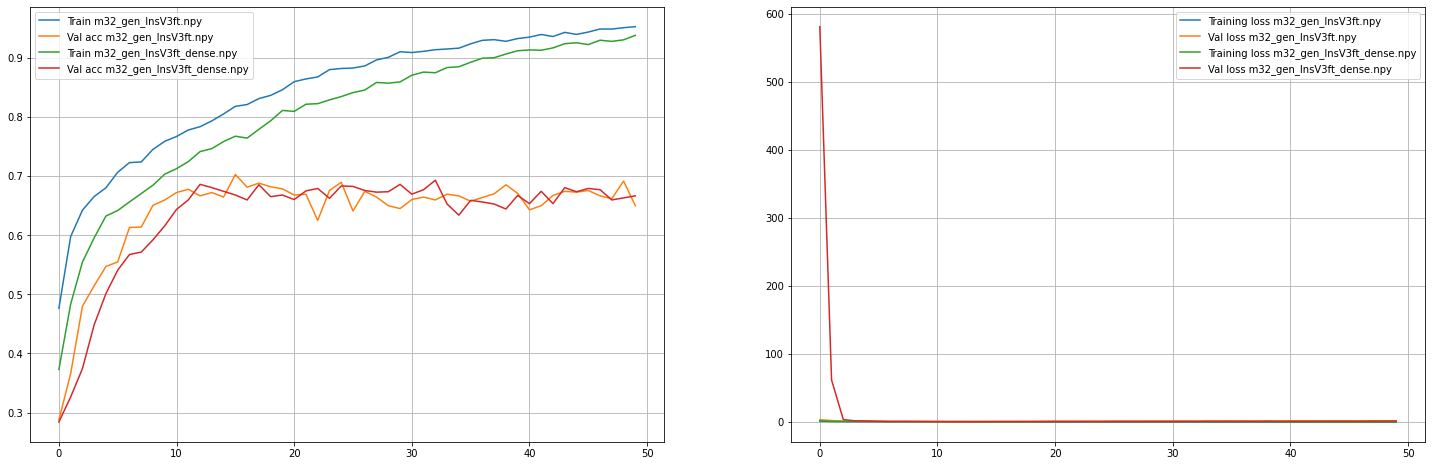

In [ ]:
pre_trained_model.trainable = True
trainerNtimes_generator_saveInitModel(times2run_trainer, GeneralPreTrainedModelDense, 
                                      pre_trained_model, img, labels_train, learning_rate, 
                                      k, EPOCH, BATCH, save_model, 
                                      os.path.join(metrics_path, "m32_gen_InsV3ft_dense"))
PlotFiles(("m32_gen_InsV3ft.npy", "m32_gen_InsV3ft_dense.npy"))

At fine-tuning, the InceptionV3 model with an addional dense layer, shows similar performance as the InceptionV3 without that addional dense layer.

##Comparing Results
In this subsection, the best models are confronted, first, the pre-trained model in which they are based, and then the best of them.

###VGG16: Feature Extractor Dense vs Fine Tuning Flat
In the VGG16 side, the fine-tuned model without the addional layer perfomance better that feature extractor only with the addional layer. However the fine-tuning presents over-fitting. Something the dense-er layer does not have it, but it is limited to 60% accuracy.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

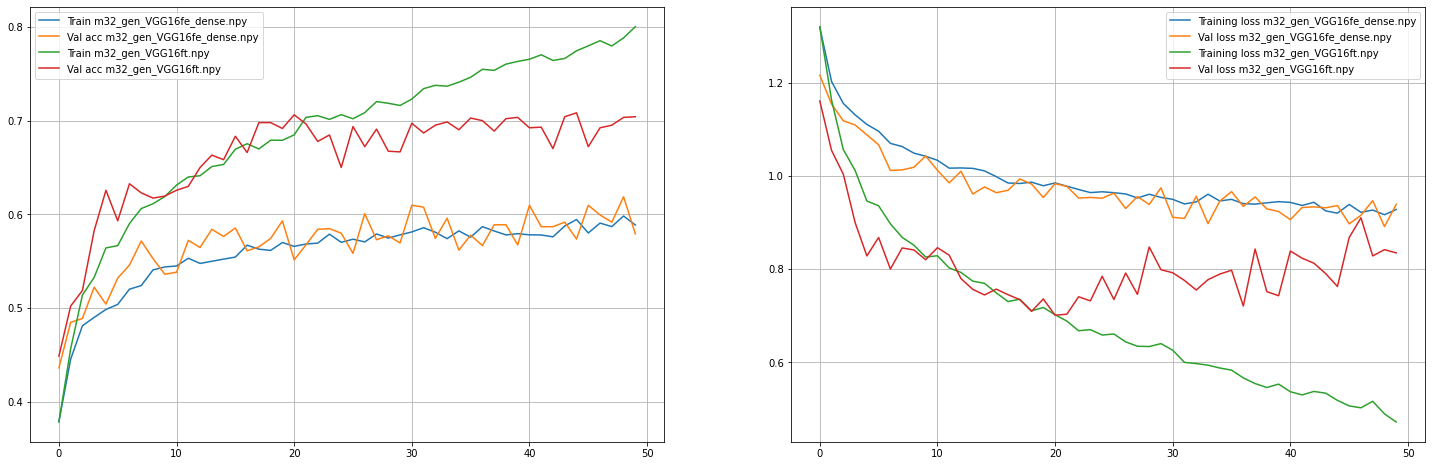

In [ ]:
PlotFiles(("m32_gen_VGG16fe_dense.npy", "m32_gen_VGG16ft.npy"))

###InceptioV3: Feature Extrator Dense vs Fine Tuning
In the InceptionV3 side, the fine-tuning without addional dense layer also performs better of all the other model variations, so far. However, in similar case as the VGG16-based model, the fine-tuning creates over-fitting.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

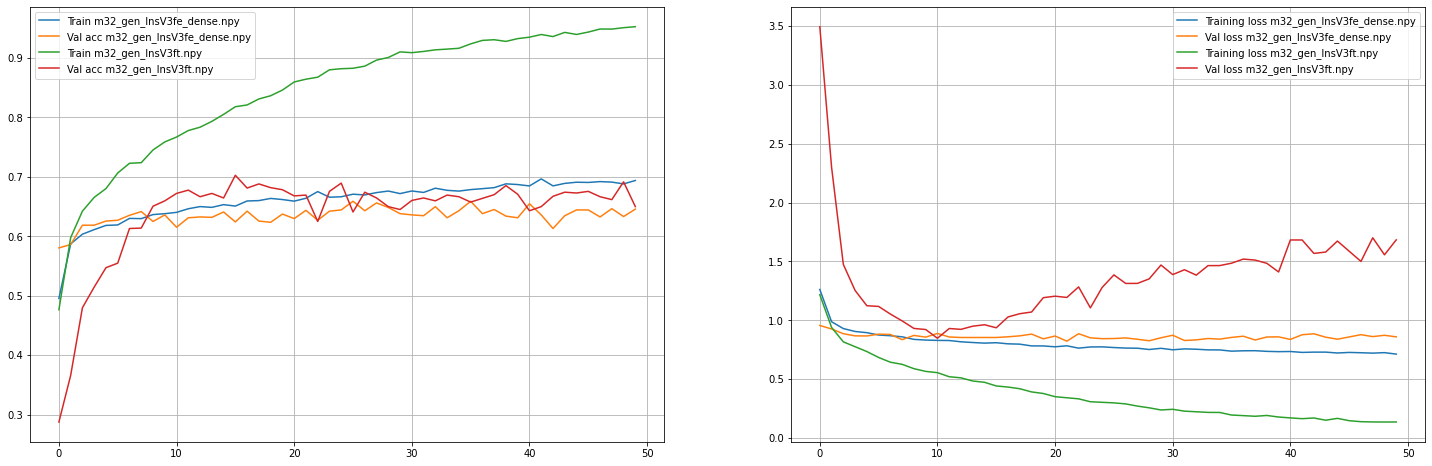

In [ ]:
PlotFiles(("m32_gen_InsV3fe_dense.npy", "m32_gen_InsV3ft.npy"))

###Best of InceptioV3 vs VGG16
In the following picture the best models are compared, there's no much difference between them. The InceptionV3 has good accuracy at training but that comes with an larger over-fitting, seen in loss curves.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

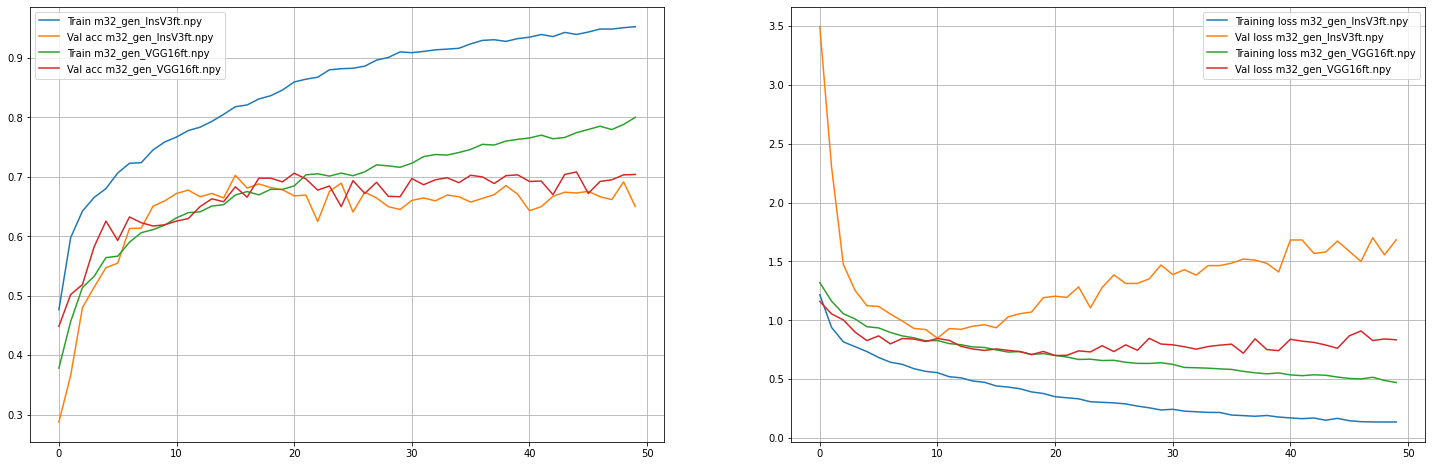

In [ ]:
PlotFiles(("m32_gen_InsV3ft.npy", "m32_gen_VGG16ft.npy"))


#Model with Dropout
In order to remove or avoid the over-fitting, a dropout layer will be added, the function below implements the model with any desired dropout rate passed in arg.

In [ ]:
def GeneralPreTrainedModelDropout(arg):
  
  # add new classifier layers
  flat1 = layers.Flatten()(arg[0].layers[-1].output)
  dropout1 = layers.Dropout(arg[1])(flat1)
  # 4 OUTPUTS with SOFTMAX
  output = layers.Dense(4, activation='softmax')(dropout1)

  # define new pre-trained model
  model_return = models.Model(inputs=arg[0].inputs, outputs=output)

  # summarize the pre-trained model
  model_return.summary()
  return model_return

##VGG16 \w 50% dropout
The first mode to be evaluated is the VGG16 with a 50% dropout rate. From previous experice, it's known that 50% is a good start, if the network gets worse in comparison to the full model: 50% was too much, so, the dropout rate has to be decreased. On the other hand, if the performance is kept, then 50% wasnt enough dropping, so, increasing the rate until some performance change is seen. The same reasoning will be applied for the InceptionV3 model.

As usual a two-stage trained is performed: a feature extractor followed by a fine-tunning.

In [ ]:
del pre_trained_model 
pre_trained_model = VGG16(include_top=False, input_shape=(width, height, 3)) # VGG16 model

# Set the model as feature 
pre_trained_model.trainable = False

[RUNNING@ 0 ] with arg (<tensorflow.python.keras.engine.functional.Functional object at 0x7f5e7212f780>, 0.5)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

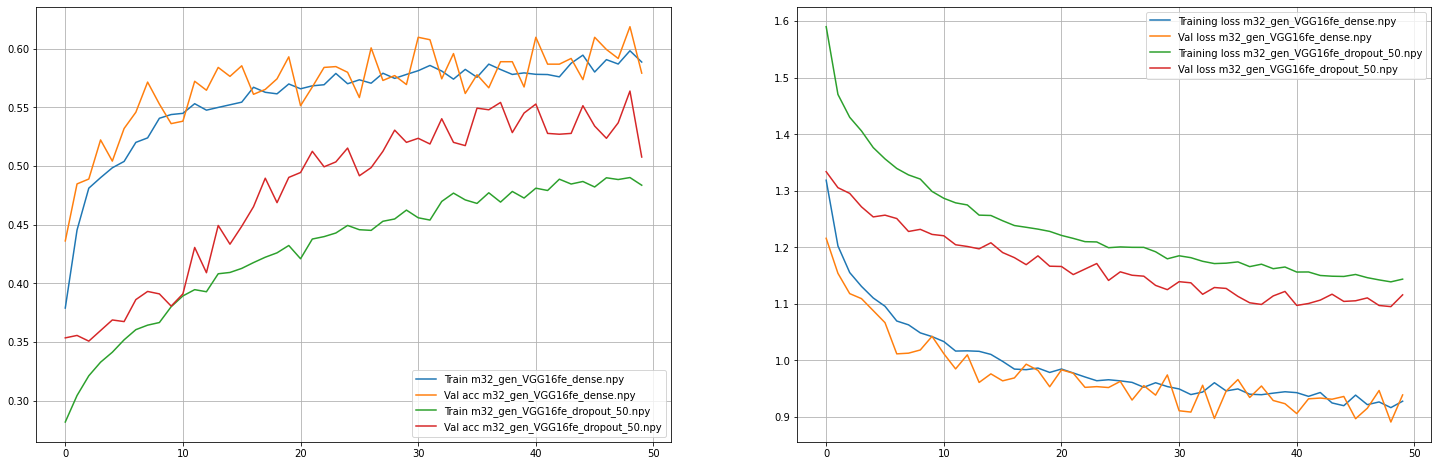

In [ ]:
trainerNtimes_generator_saveInitModel(times2run_trainer, GeneralPreTrainedModelDropout,
                                      (pre_trained_model, 0.5), img, labels_train, learning_rate, 
                                      k, EPOCH, BATCH, save_model, 
                                      os.path.join(metrics_path, "m32_gen_VGG16fe_dropout_50"))
PlotFiles(("m32_gen_VGG16fe_dense.npy", "m32_gen_VGG16fe_dropout_50.npy"))

###Fine Tuning

[RUNNING@ 0 ] with arg (<tensorflow.python.keras.engine.functional.Functional object at 0x7f5e7212f780>, 0.5)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

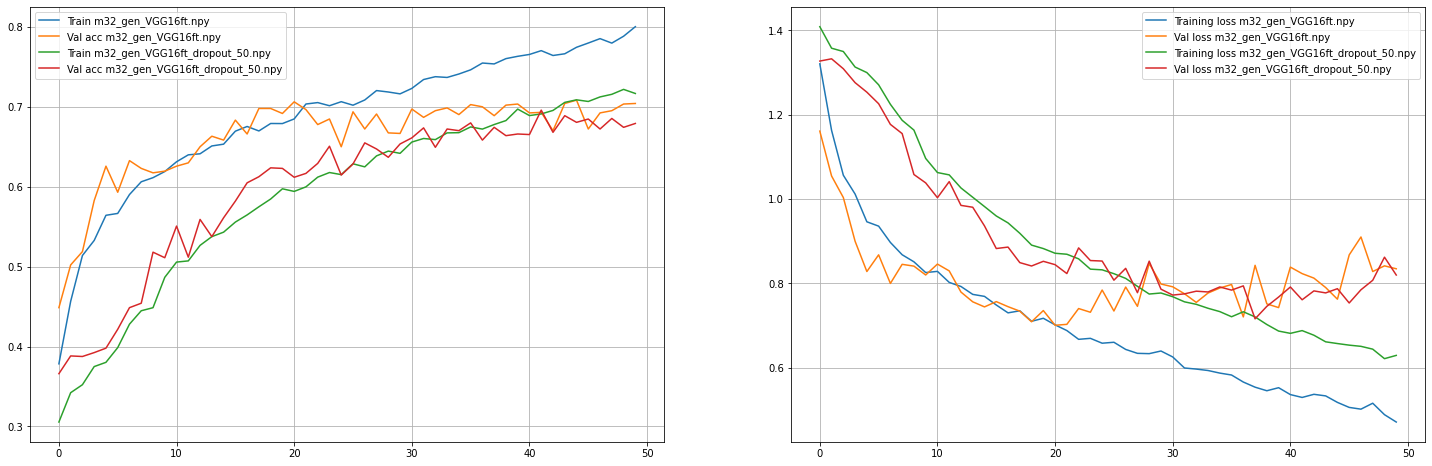

In [ ]:
pre_trained_model.trainable = True
trainerNtimes_generator_saveInitModel(times2run_trainer, GeneralPreTrainedModelDropout,
                                      (pre_trained_model, 0.5), img, labels_train, learning_rate, 
                                      k, EPOCH, BATCH, save_model, 
                                      os.path.join(metrics_path, "m32_gen_VGG16ft_dropout_50"))
PlotFiles(("m32_gen_VGG16ft.npy", "m32_gen_VGG16ft_dropout_50.npy"))

Indeed, for the VGG16 a 50% dropout was too much, the learning speed is slower and in terms of accuracy is slitly smaller than its non-dropping counterpart.

##VGG16 \w 25% dropout
Based on the 50% dropout rate of the VGG16, this new experiment presents a 25% dropping rate in order to avoid the low performance of the network. As usual is a two stage training.

In [ ]:
del pre_trained_model 
pre_trained_model = VGG16(include_top=False, input_shape=(width, height, 3)) # VGG16 model

# Set the model as feature 
pre_trained_model.trainable = False

[RUNNING@ 0 ] with arg (<tensorflow.python.keras.engine.functional.Functional object at 0x7f5e7d58bba8>, 0.25)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

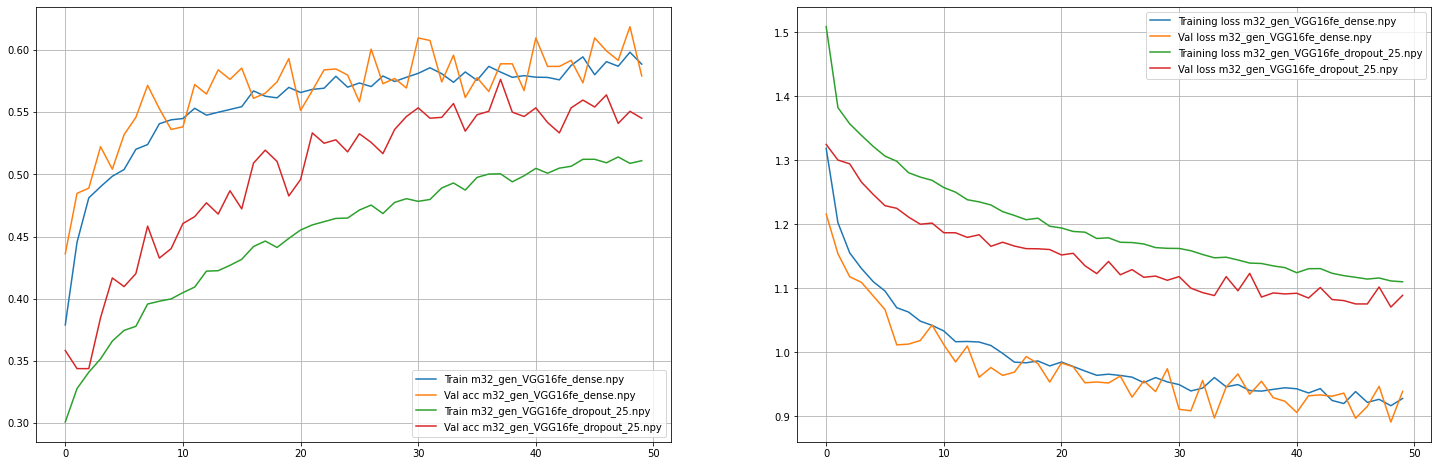

In [ ]:
trainerNtimes_generator_saveInitModel(times2run_trainer, GeneralPreTrainedModelDropout,
                                      (pre_trained_model, 0.25), img, labels_train, learning_rate, 
                                      k, EPOCH, BATCH, save_model, 
                                      os.path.join(metrics_path, "m32_gen_VGG16fe_dropout_25"))
PlotFiles(("m32_gen_VGG16fe_dense.npy", "m32_gen_VGG16fe_dropout_25.npy"))

### Fine Tuning

[RUNNING@ 0 ] with arg (<tensorflow.python.keras.engine.functional.Functional object at 0x7f5e7d58bba8>, 0.25)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

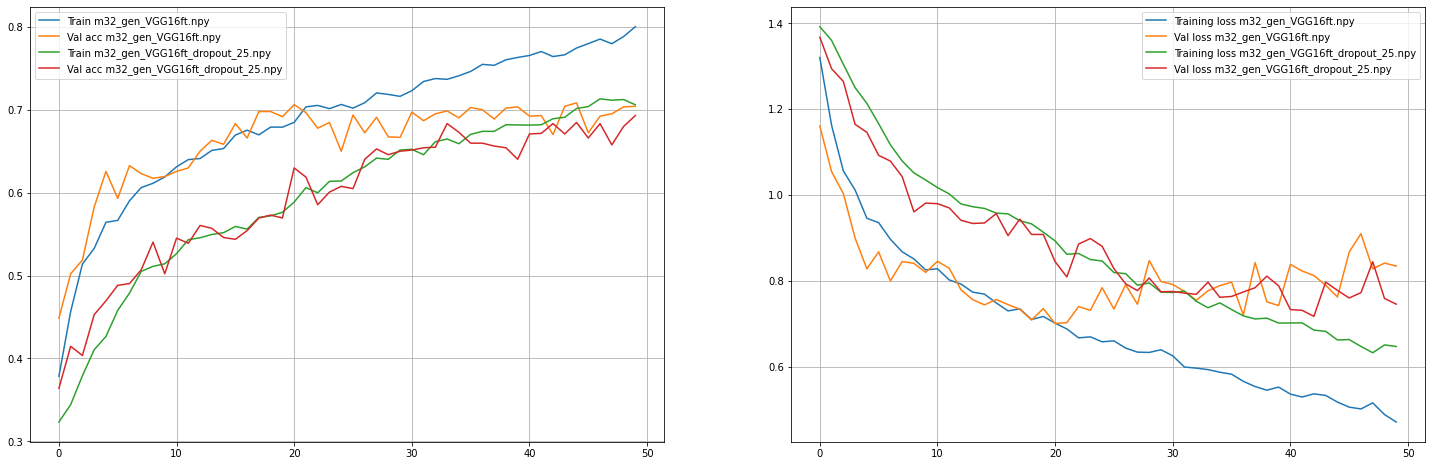

In [ ]:
pre_trained_model.trainable = True 
trainerNtimes_generator_saveInitModel(times2run_trainer, GeneralPreTrainedModelDropout,
                                      (pre_trained_model, 0.25), img, labels_train, learning_rate, 
                                      k, EPOCH, BATCH, save_model, 
                                      os.path.join(metrics_path, "m32_gen_VGG16ft_dropout_25"))
PlotFiles(("m32_gen_VGG16ft.npy", "m32_gen_VGG16ft_dropout_25.npy"))

Nop, dropping-out neurons at the end of the VGG16 model does not increase the networks performance. So, the best of VGG comes from the fine-tuned flatten VGG16, meaning, no addional dense, no dropout.

##InceptionV3 \w 50% dropout
Now, it's InceptionV3 model's turn to be evaluated with a dropout layer. The first experiments drops 50% out of the neurons at the output of the InceptionV3 layer. Based on those results, the dropping will be increase or decrease for the next experiment. AS usual, the training is a two stage training.

In [ ]:
del pre_trained_model 
pre_trained_model = InceptionV3(include_top=False, input_shape=(width, height, 3)) 

# Set the model as feature 
pre_trained_model.trainable = False

[RUNNING@ 0 ] with arg (<tensorflow.python.keras.engine.functional.Functional object at 0x7f5e84085ba8>, 0.5)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalizatio

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

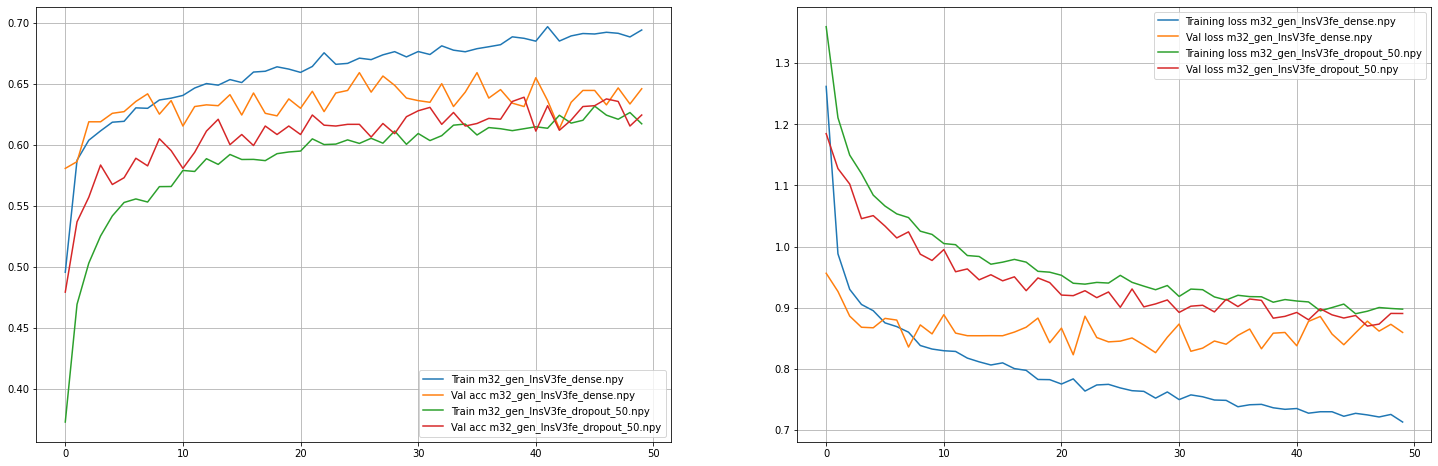

In [ ]:
trainerNtimes_generator_saveInitModel(times2run_trainer, GeneralPreTrainedModelDropout, 
                                      (pre_trained_model, 0.5), img, labels_train, learning_rate, 
                                      k, EPOCH, BATCH, save_model, 
                                      os.path.join(metrics_path, "m32_gen_InsV3fe_dropout_50"))
PlotFiles(("m32_gen_InsV3fe_dense.npy", "m32_gen_InsV3fe_dropout_50.npy"))

###Fine Tuning

[RUNNING@ 0 ] with arg (<tensorflow.python.keras.engine.functional.Functional object at 0x7f5e84085ba8>, 0.5)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalizatio

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

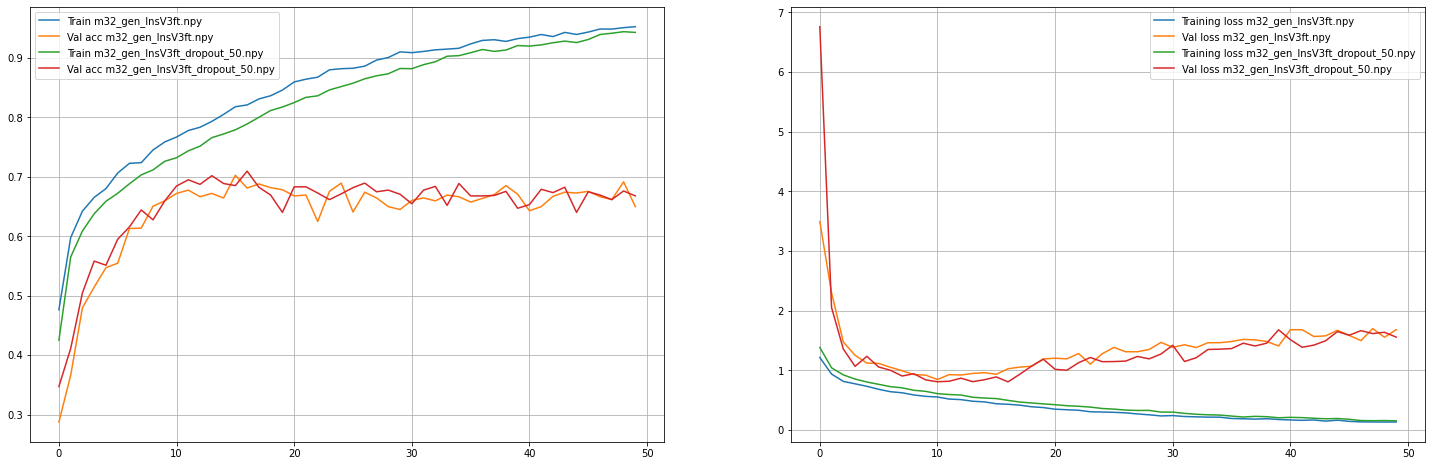

In [ ]:
pre_trained_model.trainable = True
trainerNtimes_generator_saveInitModel(times2run_trainer, GeneralPreTrainedModelDropout, 
                                      (pre_trained_model, 0.5), img, labels_train, learning_rate, 
                                      k, EPOCH, BATCH, save_model, 
                                      os.path.join(metrics_path, "m32_gen_InsV3ft_dropout_50"))
PlotFiles(("m32_gen_InsV3ft.npy", "m32_gen_InsV3ft_dropout_50.npy"))

Unlike VGG16, InceptionV3 with a 50% dropping rate indeed shows a slight performance in the accuracy and loss, this is a clue for the dropping rate to go higher.

##InceptionV3 \w 80% dropout
Based on the Previous experiment of the InceptionV3, in this experiment 80% dropping rate is applied, if this aggravets the net's performance, the 50% will be kept. AS usual, two-stage training.

In [ ]:
del pre_trained_model 
pre_trained_model = InceptionV3(include_top=False, input_shape=(width, height, 3)) 

# Set the model as feature 
pre_trained_model.trainable = False

87916544/87910968 [==============================] - 1s 0us/step


[RUNNING@ 0 ] with arg (<tensorflow.python.keras.engine.functional.Functional object at 0x7f72841e8e80>, 0.8)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalizatio

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

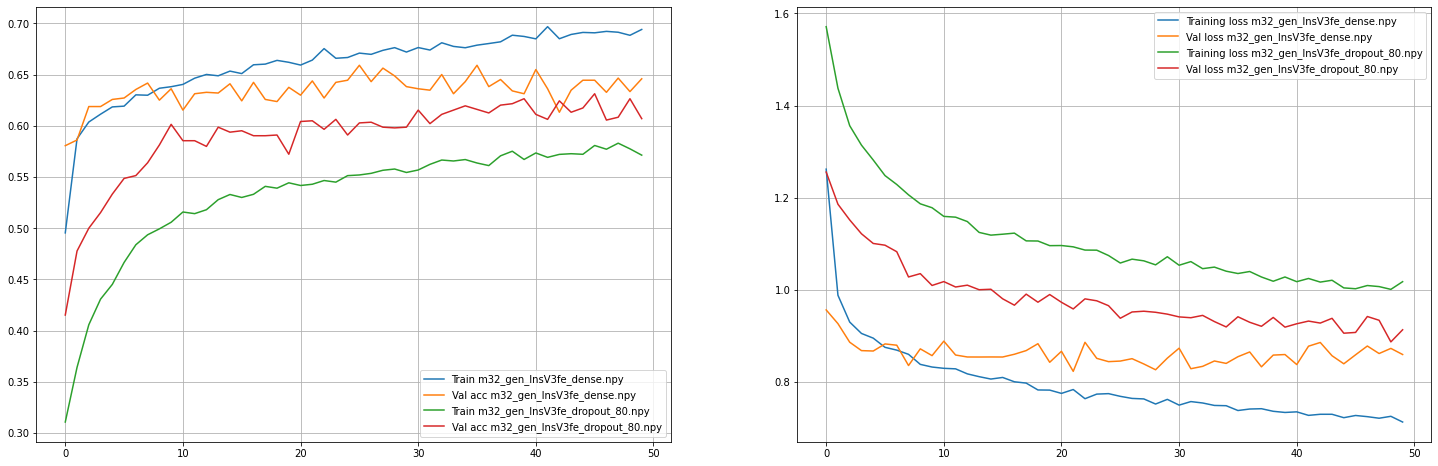

In [ ]:
trainerNtimes_generator_saveInitModel(times2run_trainer, GeneralPreTrainedModelDropout, 
                                      (pre_trained_model, 0.80), img, labels_train, learning_rate, 
                                      k, EPOCH, BATCH, save_model, 
                                      os.path.join(metrics_path, "m32_gen_InsV3fe_dropout_80"))
PlotFiles(("m32_gen_InsV3fe_dense.npy", "m32_gen_InsV3fe_dropout_80.npy"))

###Fine Tuning

[RUNNING@ 0 ] with arg (<tensorflow.python.keras.engine.functional.Functional object at 0x7f72841e8e80>, 0.8)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalizatio

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

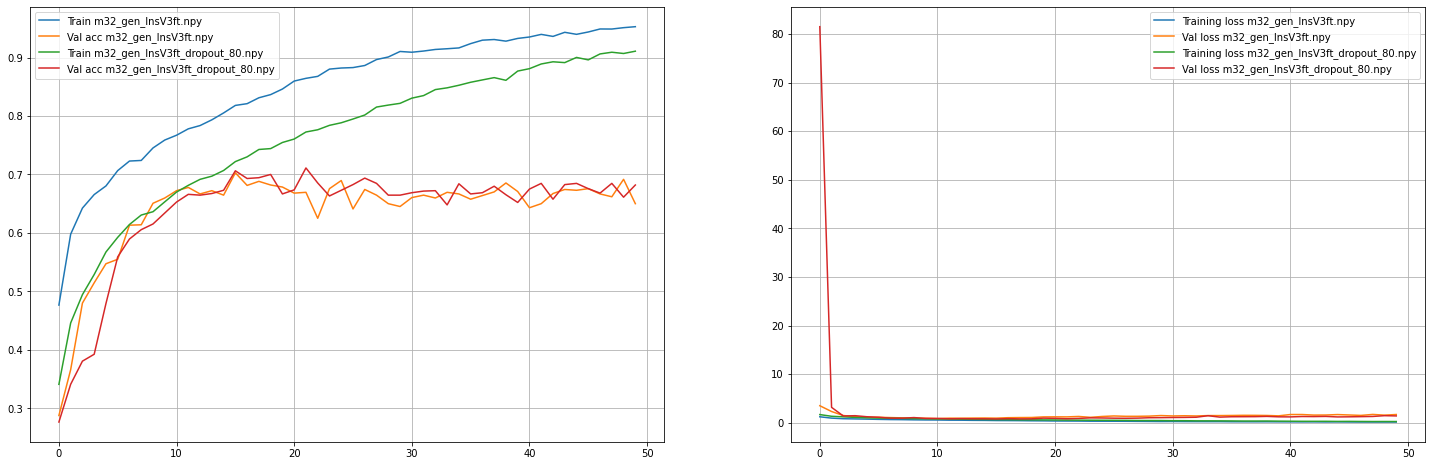

In [ ]:
pre_trained_model.trainable = True
trainerNtimes_generator_saveInitModel(times2run_trainer, GeneralPreTrainedModelDropout, 
                                      (pre_trained_model, 0.80), img, labels_train, learning_rate, 
                                      k, EPOCH, BATCH, save_model, 
                                      os.path.join(metrics_path, "m32_gen_InsV3ft_dropout_80"))
PlotFiles(("m32_gen_InsV3ft.npy", "m32_gen_InsV3ft_dropout_80.npy"))

The results of the 80% dropping rate on the InceptionV3 dont show significant improvement in the model, therefore 50% of dropping rate will be kept.

# Validation Confusion Matrix

Dispite all diferent experiments performed, the maximum accuracy of both VGG16-based and InceptionV3-based at maximum over pass the 70%. In order to chose either the fine-tuned flatten VGG16 or the fine-tuned dropout@50 InceptionV3 model, one more comparison will be held. Their validation Confusion Matrix, this tells how well the model is capable to discriminate the classes.

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

def trainModel_w_kFold_n_aug_confusion_mm(model, img, labels_train, optmz, kFold, epoch, batch_size):
  # Implements K-FOLD

  depth, _, _, _ = img.shape;
  chunk = depth // kFold

  idx = np.arange(depth);
  np.random.shuffle(idx);

  # generator
  train_datagen = ImageDataGenerator(rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     )

  # model
  model.compile(optimizer = optmz, loss="categorical_crossentropy")
  model.save_weights(base_path+'task32_pretrained_gen_cm.h5')

  # metrics
  val_acc = 0.0
  cmm = np.zeros([4, 4])

  for fold in range(kFold):
    print('START,',fold+1,'/',kFold,'--------------------------------------------------------------------------------')
    
    # k-fold
    valid = idx[fold * chunk : (fold + 1) * chunk];
    train = np.concatenate((idx[:fold * chunk], idx[(fold + 1) * chunk:]), axis=0)

    # Generator    
    train_generator = train_datagen.flow(img[train], labels_train[train], batch_size=batch_size)

    model.load_weights(base_path+'task32_pretrained.h5')

    # Train
    h = model.fit(train_generator, steps_per_epoch=np.ceil(train.shape[0]/batch_size), 
                  epochs=epoch, verbose=0)    
    
    # Validation Confusion Matrix
    y_pred = model.predict(img[valid])
    labels_train_val = labels_train[valid]

    cmm = cmm + confusion_matrix(labels_train_val.argmax(axis=1), y_pred.argmax(axis=1), [0, 1, 2, 3])
    val_acc = val_acc + accuracy_score(labels_train_val.argmax(axis=1), y_pred.argmax(axis=1))    

    print('=> val acc:', accuracy_score(labels_train_val.argmax(axis=1), y_pred.argmax(axis=1)))

    print('DONE------------------------------------------------------------------------------------------')
    reset_weights(model)

    
  cmm_norm = np.sum(cmm)
  
  print("Overall val_acc: ", val_acc / (1.*kFold))
  
  return cmm/cmm_norm, val_acc / (1.*kFold)

def trainerNtimes_generator_confusion_mm(n_times, genModelx, arg, img, labels_train, lr, k, EPOCH, BATCH, saveIt, fileName):
  # Runs n_times the k-fold algorithm
  cmm = []
  val_acc = []

  # Notifies, a training has started
  BotNotifier("Starting pretrained_32 with " + str(arg))

  for x in range(n_times):
    print('[RUNNING@',x,'] with arg',arg)
    backend.clear_session()

    # model and optimizer creation
    adam = Adam(lr=lr);
    model = genModelx(arg);

    # calls k-fold algorithm
    a, b  = trainModel_w_kFold_n_aug_confusion_mm(model, img, labels_train, adam, k, EPOCH, BATCH)
    
    # memory release
    del model
    del adam

    # log metrics
    cmm.append(a)
    val_acc.append(b)

  # average metrics
  cmm = np.average(cmm, axis=0)
  val_acc = np.average(val_acc, axis=0)

  # save metrics
  if (saveIt): 
    np.save(fileName, np.stack(cmm))
  # messages training is over
  BotNotifier("Done on pretrained32 with " + str(arg))
  return cmm, val_acc

def plot_confusion_matrix(cm, num_classes, labels, title='Confusion matrix', cmap=plt.cm.Greys):
  # plots n = size(cm) confusion matrix in nx2 subplots

  rows = np.ceil(len(cm)/2)
  cm_idx = 1
  cols = 2

  plt.figure(figsize=(15, rows*6))

  for files in cm:
    if files is not None:
      cm_i = np.load(os.path.join(metrics_path, files))
      plt.subplot(rows, cols, cm_idx)
      plt.imshow(cm_i, interpolation='nearest', cmap=cmap)
      plt.title(files)
      plt.colorbar()
      tick_marks = np.arange(num_classes)
      plt.xticks(tick_marks, labels)
      plt.yticks(tick_marks, labels)
      plt.tight_layout()
      plt.ylabel('True label')
      plt.xlabel('Predicted label')
      print(files)
      print("=>", cm_i, "\n")

      cm_idx += 1

  plt.show() 

Control Confusion Matrix, the perfect classifier should predict exactly the same validation labels

task32_validation_control_cm.npy
=> [[0.23168909 0.         0.         0.        ]
 [0.         0.22346786 0.         0.        ]
 [0.         0.         0.35426009 0.        ]
 [0.         0.         0.         0.19058296]] 



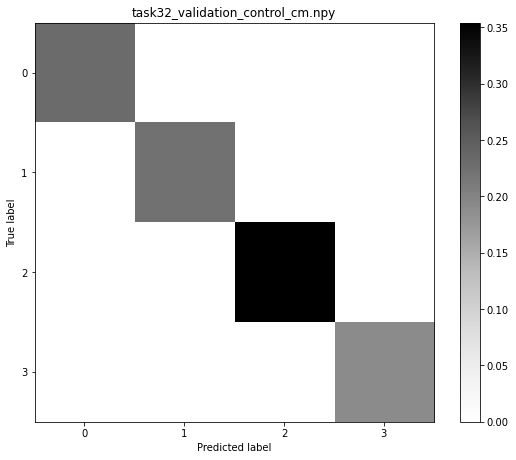

In [ ]:
cmm = confusion_matrix(labels_train.argmax(axis=1), labels_train.argmax(axis=1), [0, 1, 2, 3])
cmm = cmm/np.sum(cmm)
np.save(os.path.join(metrics_path, "task32_validation_control_cm.npy"), np.stack(cmm))
plot_confusion_matrix(("task32_validation_control_cm.npy", None), 4, [0, 1, 2, 3])

In [ ]:
del pre_trained_model

## Flatten VGG16 confusion matrix
The Flatten VGG16 model will be evaluated by being trained in two stages and applying early stopping. From the previous experiment it was observed the feature extractor has the minimum loss at 50th epoch and the fine-tuning at 20th.

In [ ]:
pre_trained_model = VGG16(include_top=False, input_shape=(width, height, 3)) # VGG16 model

# Set the model as feature 
pre_trained_model.trainable = False
trainerNtimes_generator_confusion_mm(times2run_trainer, GeneralPreTrainedModel,
                                      pre_trained_model, img, labels_train, 
                                      learning_rate, k, 50, BATCH, save_model, 
                                      os.path.join(metrics_path, "dump_file31"))
# Fine tuning
pre_trained_model.trainable = True
trainerNtimes_generator_confusion_mm(times2run_trainer, GeneralPreTrainedModel,
                                      pre_trained_model, img, labels_train, 
                                      learning_rate, k, 20, BATCH, save_model, 
                                      os.path.join(metrics_path, "task32_flatten_vgg16_cm"))
del pre_trained_model

[RUNNING@ 0 ] with arg <tensorflow.python.keras.engine.functional.Functional object at 0x7f25f8325048>
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
________________________

## Dropout50 InceptionV3 confusion matrix
The Dropout50 InceptionV3 model will be evaluated by being trained in two stages and applying early stopping. From the previous experiment it was observed the feature extractor has the minimum loss at 50th epoch and the fine-tuning at 13th.

In [ ]:
pre_trained_model = VGG16(include_top=False, input_shape=(width, height, 3)) # VGG16 model

# Set the model as feature 
pre_trained_model.trainable = False
trainerNtimes_generator_confusion_mm(times2run_trainer, GeneralPreTrainedModelDropout,
                                      (pre_trained_model, 0.5), img, labels_train, 
                                      learning_rate, k, 50, BATCH, save_model, 
                                      os.path.join(metrics_path, "dump_file31"))
# Fine tuning
pre_trained_model.trainable = True
trainerNtimes_generator_confusion_mm(times2run_trainer, GeneralPreTrainedModelDropout,
                                      (pre_trained_model, 0.5), img, labels_train, 
                                      learning_rate, k, 13, BATCH, save_model, 
                                      os.path.join(metrics_path, "task32_dropout_InsV3_cm"))
del pre_trained_model

[RUNNING@ 0 ] with arg (<tensorflow.python.keras.engine.functional.Functional object at 0x7fefc0718b70>, 0.5)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________

In the next section, the perfect classifier is confronted to the two VGG16's confusion matrix and the InceptionV3's. the VGG16 does overall good at discriminating all classes in comparison with the inceptionV3 who only does good at the class with abundant data. 

The best model for this approach is the flatten VGG16 with two-stage training.

task32_validation_control_cm.npy
=> [[0.23168909 0.         0.         0.        ]
 [0.         0.22346786 0.         0.        ]
 [0.         0.         0.35426009 0.        ]
 [0.         0.         0.         0.19058296]] 

task32_flatten_vgg16_cm.npy
=> [[0.17084112 0.04448598 0.01158879 0.00485981]
 [0.05682243 0.14280374 0.01084112 0.01271028]
 [0.01420561 0.01345794 0.26280374 0.06392523]
 [0.00336449 0.01607477 0.06654206 0.1046729 ]] 

task32_dropout_InsV3_cm.npy
=> [[0.04485981 0.03252336 0.15102804 0.00336449]
 [0.03364486 0.02654206 0.15588785 0.0071028 ]
 [0.01009346 0.00785047 0.31700935 0.01943925]
 [0.00747664 0.00598131 0.15700935 0.02018692]] 



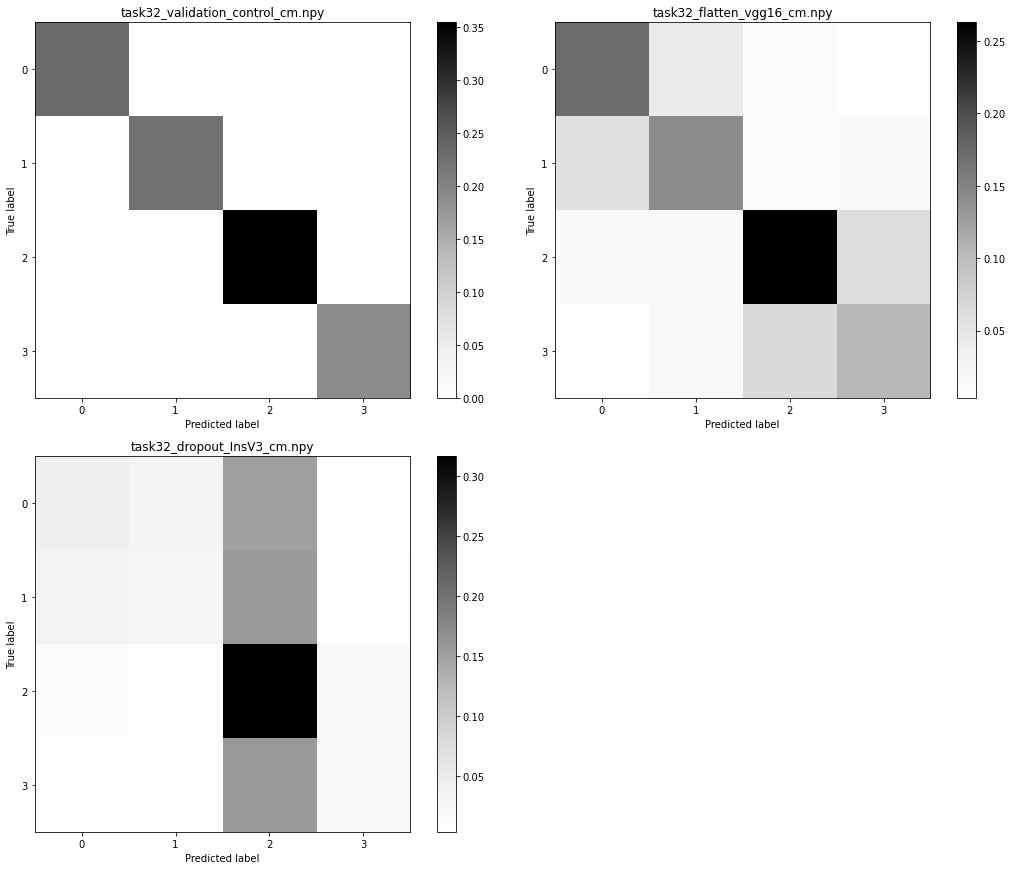

In [ ]:
plot_confusion_matrix(("task32_validation_control_cm.npy", "task32_flatten_vgg16_cm.npy", "task32_dropout_InsV3_cm.npy"), 4, [0, 1, 2, 3])

# Ultimate Training
Training the model and saving it, the training is done applying early stopping at epoch 50 when feature extractor and 20 when fine-tunning are executed.

In [ ]:
def train_only(modelFoo, arg, lr, img, labels_train, epoch, batch_size, model_name):
  model = modelFoo(arg)
  adam = Adam(lr=lr)
  model.compile(optimizer = adam, loss="categorical_crossentropy")

  # Generator
  train_datagen = ImageDataGenerator(rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True)
  train_generator = train_datagen.flow(img, labels_train, batch_size=batch_size)

  # Train
  model.fit(train_generator, steps_per_epoch=np.ceil(labels_train.shape[0]/batch_size), 
              epochs=epoch, verbose=1)
  # Save Model
  print('Model Save at:', base_path+model_name)
  model.save(base_path+model_name)

def loadModel_fromFile(model2load):
  return models.load_model(base_path+model2load)

two stage training

In [ ]:
#del pre_trained_model 
pre_trained_model = VGG16(include_top=False, input_shape=(width, height, 3)) 
pre_trained_model.trainable = False

# Feature extrator training 
train_only(GeneralPreTrainedModel, pre_trained_model, learning_rate, img, labels_train, 50, BATCH, "task32_fe_model.h5")
# Release memory
del pre_trained_model

# Fine Tune
train_only(loadModel_fromFile, "task32_fe_model.h5", learning_rate, img, labels_train, 20, BATCH, "task32_ft_model.h5")

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0   

# Test

## Loading test data

In [ ]:
img_test = np.load(base_path+'dataset/public_test_tensor.npy') 
labels = np.load(base_path+'dataset/public_test_labels.npy') 
depth_test, width_test, height_test = img_test.shape # shape of the train label depth_val, width_val, height_val = images_val.shape # shape of the train label

Processing data

Since the VGG16 model requires a 3-channel image, the monochromatic mammographies are casted into a 3-channel by triplicating its unique channel.

In [ ]:
labels_test = np.array([]);
idx = [];

# Extracting Abnormalities from data set, and vectorizing the training labels
for i in range(depth_test):

  if (labels[i] == 1):    # Mass, Benign
    idx.append(i)
    labels_test = np.append(labels_test, [1., 0., 0., 0.])

  elif (labels[i] == 2):  # Mass, Malignant
    idx.append(i)
    labels_test = np.append(labels_test, [0., 1., 0., 0.])

  elif (labels[i] == 3):  # Calcification, Benign
    idx.append(i)
    labels_test = np.append(labels_test, [0., 0., 1., 0.])

  elif (labels[i] == 4):  # Calcification, Malignant
    idx.append(i)
    labels_test = np.append(labels_test, [0., 0., 0., 1.])

# Filter abnormalities from full image set
img2_test = img_test[idx];
depth_test = idx.__len__()
labels_test = labels_test.reshape(depth_test, 4)

# 3-COLOUR CHANNELS
# Triple the black and white colour to a 3-colour channel 
img_test = np.zeros((depth_test, width_test, height_test, 3))

for i in range(depth_test):
  img_test[i, :, :, 0] = img2_test[i]
  img_test[i, :, :, 1] = img2_test[i]
  img_test[i, :, :, 2] = img2_test[i]

# Normalization
img_test = img_test.astype('float32') / 65535;

Test confusion matrix, a perfect classifier will predict all classes in the same proportion as the test data. This will be used for control

task32_test_control_cm.npy
=> [[0.33630952 0.         0.         0.        ]
 [0.         0.19642857 0.         0.        ]
 [0.         0.         0.31547619 0.        ]
 [0.         0.         0.         0.15178571]] 



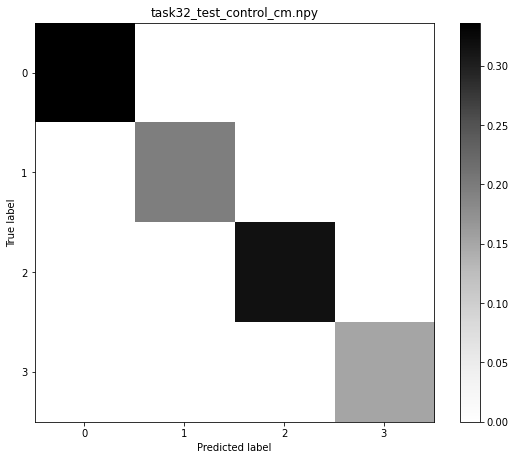

In [ ]:
cmm = confusion_matrix(labels_test.argmax(axis=1), labels_test.argmax(axis=1), [0, 1, 2, 3])
cmm = cmm/np.sum(cmm)
np.save(os.path.join(metrics_path, "task32_test_control_cm.npy"), np.stack(cmm))
plot_confusion_matrix(("task32_test_control_cm.npy", None), 4, [0, 1, 2, 3])

##Model Under Test

In [ ]:
mut = models.load_model(base_path+'models/task32_ft_model.h5')

prediction

In [ ]:
# test Prediction
y_test = mut.predict(img_test)

# Test Confusion
cmm = confusion_matrix(labels_test.argmax(axis=1), y_test.argmax(axis=1))
cmm = cmm/np.sum(cmm)

# Save Test confusion matrix
np.save(os.path.join(metrics_path, "task32_test_cm.npy"), np.stack(cmm))

# Memory release
del mut

print("ACCURACY TEST: ", accuracy_score(labels_test.argmax(axis=1), y_test.argmax(axis=1)))

ACCURACY TEST:  0.5446428571428571


Confusion Matrix Comparison

Finally, the VGG16 model performs poorly on test at discriminanting malignant abnormalities. But it does "significantly" better at discriminating benign masses an calcification. 

**Precision for Benign Mass = 0.558**, barely better than random identification

**Precision for Malignant Mass = 0.46**, poor

**Precision for Benign Calcification = 0.576**, barely better than random identification

**Precision for Malignant calcification = 0.42**, poor

task32_test_control_cm.npy
=> [[0.33630952 0.         0.         0.        ]
 [0.         0.19642857 0.         0.        ]
 [0.         0.         0.31547619 0.        ]
 [0.         0.         0.         0.15178571]] 

task32_test_cm.npy
=> [[0.22916667 0.04166667 0.05952381 0.00595238]
 [0.11607143 0.06547619 0.01190476 0.00297619]
 [0.05357143 0.01190476 0.22619048 0.02380952]
 [0.01190476 0.02083333 0.0952381  0.02380952]] 



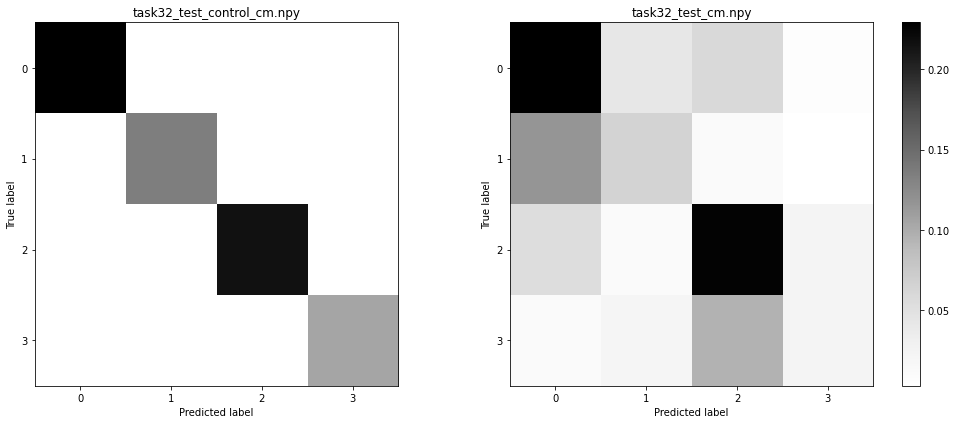

In [ ]:
plot_confusion_matrix(("task32_test_control_cm.npy", "task32_test_cm.npy"), 4, [0, 1, 2, 3])